##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [2]:
!pip install -U -q tensorflow tensorflow_datasets

In [3]:
!pip install seaborn

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-05-28 10:21:23.054031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 10:21:23.097878: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 10:21:23.098817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 10:21:23.866508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['go' 'down' 'no' 'yes' 'left' 'up' 'stop' 'right']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [10]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [11]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [12]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

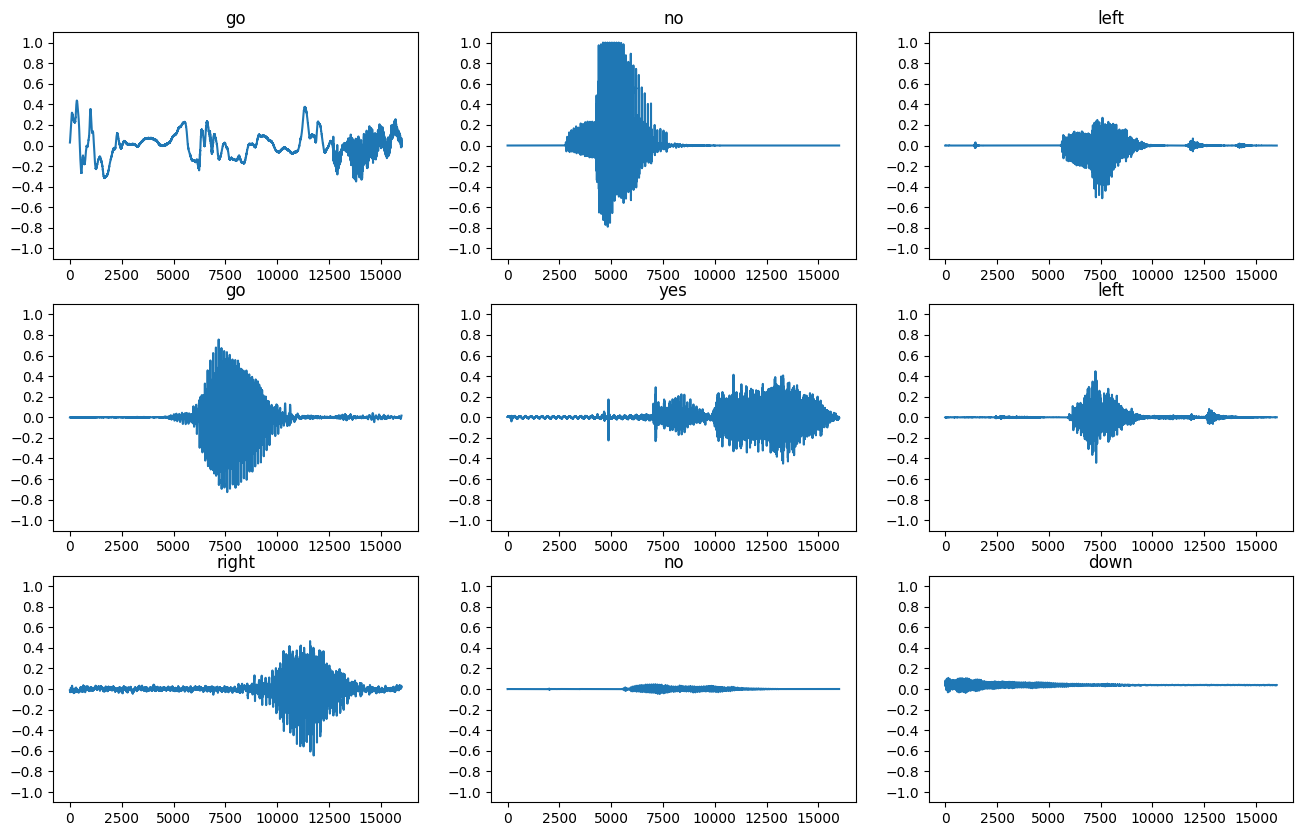

In [13]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [27]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(drof_freq(spectrogram,0.5))
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [28]:
def drof_freq(spectrogram, drop_fraction):

# Calculate the number of frequencies to keep
  num_frequencies = spectrogram.shape[2]
  num_to_keep = int(num_frequencies * (1 - drop_fraction))
 
# Randomly select indices for the frequency dimension to keep
  frequency_indices = np.random.choice(num_frequencies, num_to_keep, replace=False)

# Sort the indices (optional, to maintain some order)
  frequency_indices = np.sort(frequency_indices)

# Downsample the spectrogram by selecting the random subset of frequencies
  spectrogram_downsampled = tf.gather(spectrogram, frequency_indices, axis=2)
  
  return spectrogram_downsampled

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [29]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

IndexError: tuple index out of range

Now, define a function for displaying a spectrogram:

In [30]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

ValueError: cannot select an axis to squeeze out which has size not equal to one

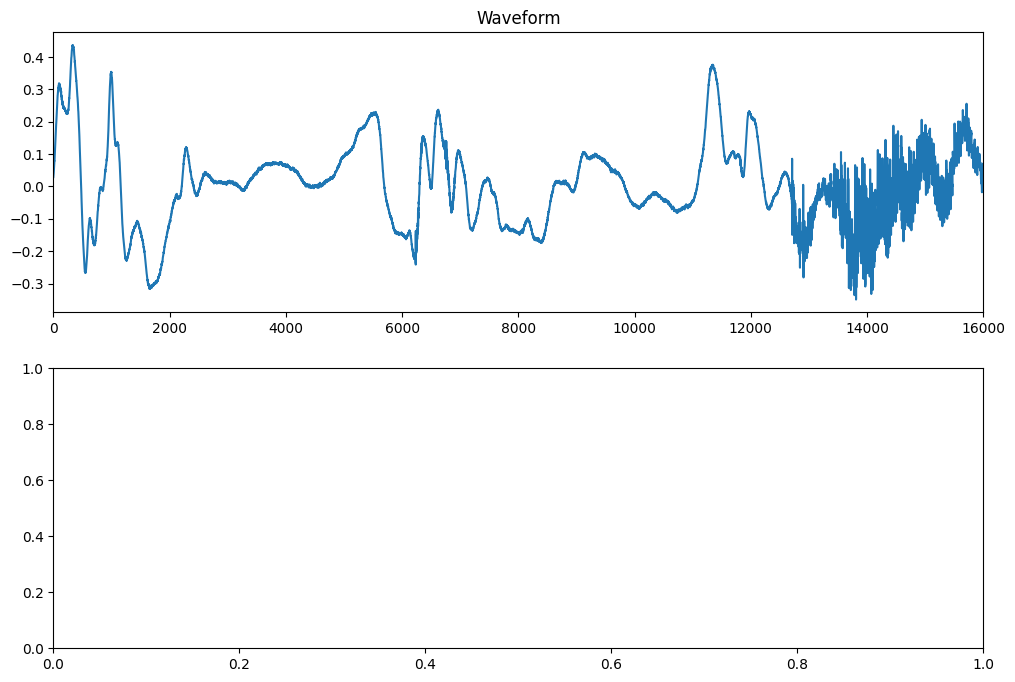

In [31]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

(10, 124, 64)


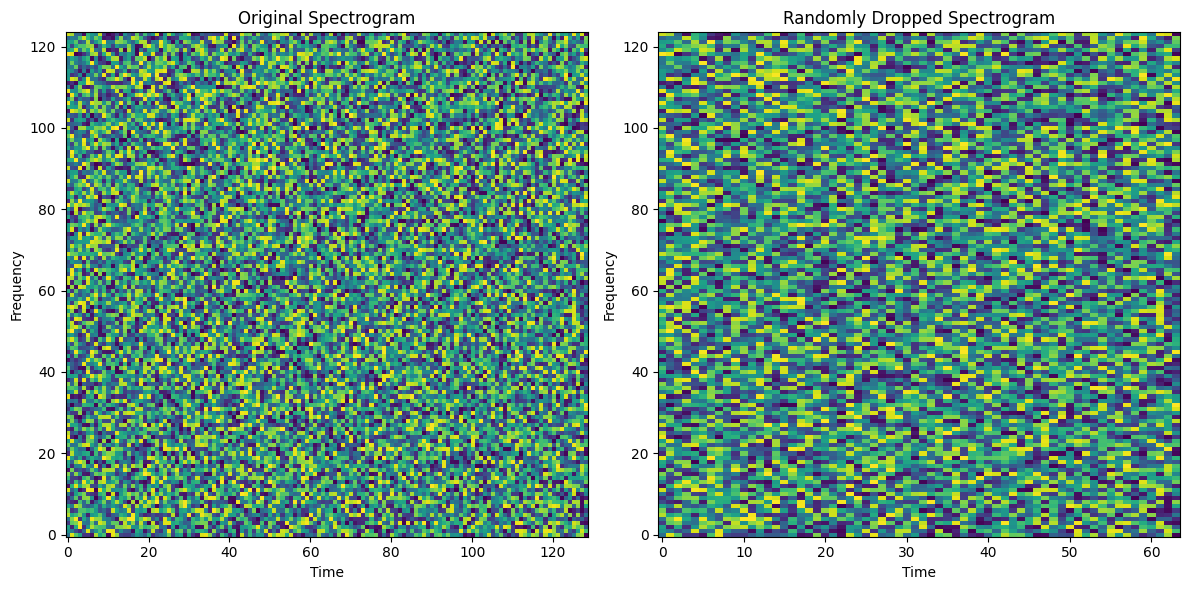

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Example spectrogram tensor (batch_size, intensity, frequency)
spectrogram = np.random.rand(10, 124, 129)

# Convert to a TensorFlow tensor
spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)

# Parameters for random dropping
drop_fraction = 0.5  # Fraction of frequency bins to drop

# Calculate the number of frequencies to keep
num_frequencies = spectrogram.shape[2]
num_to_keep = int(num_frequencies * (1 - drop_fraction))

# Randomly select indices for the frequency dimension to keep
frequency_indices = np.random.choice(num_frequencies, num_to_keep, replace=False)

# Sort the indices (optional, to maintain some order)
frequency_indices = np.sort(frequency_indices)

# Downsample the spectrogram by selecting the random subset of frequencies
spectrogram_downsampled = tf.gather(spectrogram, frequency_indices, axis=2)

# Check the shape of the downsampled spectrogram
print(spectrogram_downsampled.shape)  # Should be (batch_size, intensity, num_to_keep)

# Plot an example to visualize the downsampling effect
batch_idx = 0  # Example batch index to visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(tf.abs(spectrogram[batch_idx]).numpy(), aspect='auto', origin='lower')
plt.title('Original Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.imshow(tf.abs(spectrogram_downsampled[batch_idx]).numpy(), aspect='auto', origin='lower')
plt.title('Randomly Dropped Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Now, create spectrogram datasets from the audio datasets:

In [32]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [34]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [35]:
example_spectrograms.shape

TensorShape([64, 124, 64, 1])

In [36]:
train_spectrogram_ds[:,:,:,:10]

TypeError: '_ParallelMapDataset' object is not subscriptable

In [37]:
example_spectrograms[0].shape

TensorShape([124, 64, 1])

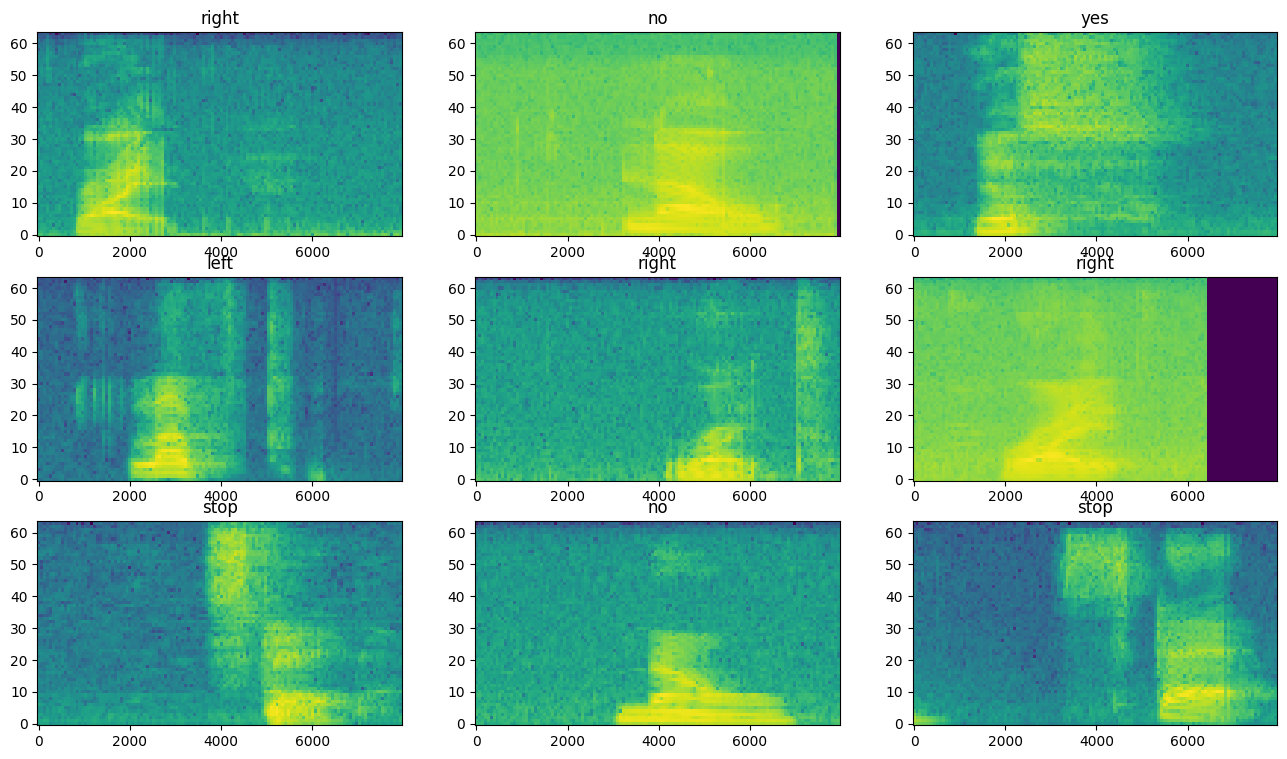

In [38]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [39]:
import tensorflow as tf
import os

# Define the directory to save the datasets
save_dir = 'saved_datasets'
os.makedirs(save_dir, exist_ok=True)

# Save the datasets
tf.data.experimental.save(train_spectrogram_ds, os.path.join(save_dir, 'train_spectrogram_ds'))
tf.data.experimental.save(val_spectrogram_ds, os.path.join(save_dir, 'val_spectrogram_ds'))
tf.data.experimental.save(test_spectrogram_ds, os.path.join(save_dir, 'test_spectrogram_ds'))

print("Datasets saved successfully.")


Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.
Datasets saved successfully.


In [1]:
import tensorflow as tf
import os
import numpy as np

# Define the directory where datasets are saved
save_dir = 'saved_datasets'

# Load the datasets
loaded_train_spectrogram_ds = tf.data.experimental.load(os.path.join(save_dir, 'train_spectrogram_ds'))
loaded_val_spectrogram_ds = tf.data.experimental.load(os.path.join(save_dir, 'val_spectrogram_ds'))
loaded_test_spectrogram_ds = tf.data.experimental.load(os.path.join(save_dir, 'test_spectrogram_ds'))

print("Datasets loaded successfully.")


2024-05-19 23:38:42.893251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 23:38:42.945418: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 23:38:42.946340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 23:38:43.840847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
Datasets loaded successfully.


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 5162954372543311547
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 7377058495073932476
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

In [2]:
pip install fastdtw

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Function to extract spectrograms from the dataset and squeeze them
def extract_spectrograms(dataset):
    spectrograms = []
    labels = []
    for spectrogram_batch, label_batch in loaded_train_spectrogram_ds:
        for spectrogram in spectrogram_batch:
            spectrograms.append(tf.squeeze(spectrogram, axis=-1).numpy())
        for label in label_batch:
            labels.append(label.numpy())
    return spectrograms, labels
# Extract spectrograms
train_spectrograms, labels_train = extract_spectrograms(loaded_train_spectrogram_ds)
val_spectrograms, labels_val = extract_spectrograms(loaded_val_spectrogram_ds)
test_spectrograms, labels_test = extract_spectrograms(loaded_test_spectrogram_ds)


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 5162954372543311547


In [4]:
def plot_spectrograms_with_labels(spectrograms, labels):
    spectrograms = np.array(train_spectrograms)
    labels = np.array(labels)
    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    spectrograms_2d = tsne.fit_transform(spectrograms.reshape(spectrograms.shape[0], -1))
    
    # Plot the 2D representation of spectrograms
    plt.figure(figsize=(10, 8))
    plt.scatter(spectrograms_2d[:, 0], spectrograms_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(label='Label')
    plt.title('Spectrograms with Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Plot the spectrograms with labels
plot_spectrograms_with_labels(train_spectrograms, labels_train)

NameError: name 'TSNE' is not defined

In [145]:
print(np.array(train_spectrograms).shape)

(6400, 124, 129)


In [ ]:
pip install joblib

In [ ]:
pip install dtaidistance

In [57]:
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# Function to compute DTW distance between two spectrograms using dtaidistance
def compute_dtw_distance(spectrogram1, spectrogram2):
    distances = []
    for k in range(spectrogram1.shape[1]):  # iterate over frequency bins
        d = dtw.distance(spectrogram1[:, k], spectrogram2[:, k])
        distances.append(d)
    return np.mean(distances)

# Wrapper function for parallel processing
def compute_distance_for_pair(spectrograms, i, j):
    distance = compute_dtw_distance(spectrograms[i], spectrograms[j])
    return i, j, distance

# Function to compute DTW similarity matrix with parallel processing
def compute_dtw_similarity_matrix(spectrograms, n_jobs=20):
    num_spectrograms = len(spectrograms)
    similarity_matrix = np.zeros((num_spectrograms, num_spectrograms))
    
    # Create a list of pairs (i, j) to compute
    pairs = [(i, j) for i in range(num_spectrograms) for j in range(i, num_spectrograms)]
    
    # Use Parallel and delayed to parallelize the computation
    results = Parallel(n_jobs=n_jobs)(delayed(compute_distance_for_pair)(spectrograms, i, j) for i, j in tqdm(pairs))
    
    # Fill in the similarity matrix with the computed distances
    for i, j, distance in results:
        similarity_matrix[i, j] = np.exp(-distance)  # Convert distance to similarity
        similarity_matrix[j, i] = similarity_matrix[i, j]  # Use symmetry
    
    return similarity_matrix
    
# Function to compute the median distance for each label group
def compute_median_distances(similarity_matrix, labels):
    unique_labels = np.unique(labels)
    median_distances = {}

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        distances = []

        for i in indices:
            for j in indices:
                if i != j:
                    distances.append(similarity_matrix[i, j])

        median_distances[label] = np.median(distances)

    return median_distances
    
def compute_iqr_thresholds(similarity_matrix, labels):
    unique_labels = np.unique(labels)
    iqr_thresholds = {}

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        distances = []

        for i in indices:
            for j in indices:
                if i != j:
                    distances.append(similarity_matrix[i, j])

        q1 = np.percentile(distances, 25)
        q3 = np.percentile(distances, 75)
        iqr = q3 - q1
        iqr_thresholds[label] = q1 - 1.5 * iqr  # Threshold for outliers

    return iqr_thresholds
    
# Function to filter the similarity matrix based on median thresholds and set diagonal to zero
def filter_similarity_matrix(similarity_matrix, labels, threshold, alpha=2):
    filtered_matrix = similarity_matrix.copy()
    
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if i == j or similarity_matrix[i, j] > threshold:
                filtered_matrix[i, j] = 0
            elif labels[i] == labels[j]:
                filtered_matrix[i, j] = alpha*similarity_matrix[i, j]

    return filtered_matrix


## Compute DTW similarity matrix for a subset (e.g., first 100 spectrograms)
subset_size = 10
subset_spectrograms = train_spectrograms[:subset_size]
subset_labels = labels_train[:subset_size]
similarity_matrix = compute_dtw_similarity_matrix(subset_spectrograms)

# Compute the median distances for each label group
median_distances = compute_median_distances(similarity_matrix, subset_labels)
#bornes_inferieures_iqr = compute_iqr_thresholds(similarity_matrix, subset_labels)
# Filter the similarity matrix based on the median thresholds and set diagonal to zero

medianes = np.array(list(median_distances.values()))
nan_mask = np.isnan(medianes)
filtered_similarity_matrix = filter_similarity_matrix(similarity_matrix, subset_labels, np.min(medianes[~nan_mask]))

print("Filtered similarity matrix computed successfully.")


100%|███████████████████████████████████████████| 55/55 [00:35<00:00,  1.56it/s]


Filtered similarity matrix computed successfully.


/home/yannick/anaconda3/envs/gnn_acoustic/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yannick/anaconda3/envs/gnn_acoustic/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
medianes = np.array(list(median_distances.values()))
nan_mask = np.isnan(medianes)
np.min(medianes[~nan_mask])

0.1211499691423362

In [58]:
import numpy as np
import pickle

# Convert subset_labels to a NumPy array
subset_labels = np.array(subset_labels)
# Append labels as an additional column
matrix_with_labels = np.hstack((subset_labels[:, np.newaxis], filtered_similarity_matrix))

# Save the matrix with labels
np.save('filtered_similarity_matrix_with_labels.npy', matrix_with_labels)
np.save('subset_spectrogram.npy', subset_spectrograms )

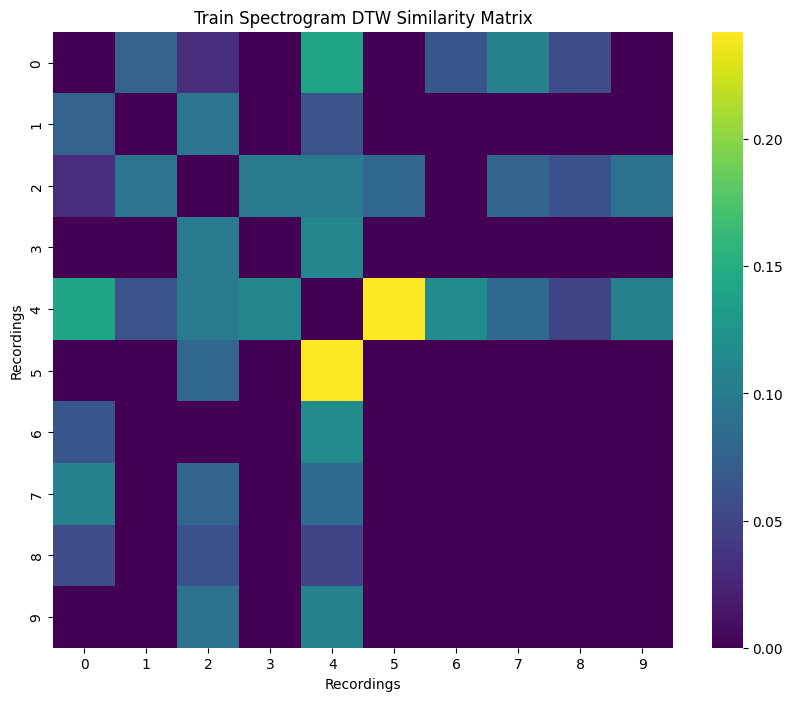

In [59]:
# Plot the DTW similarity matrix for training set
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_similarity_matrix, cmap='viridis')
plt.title('Train Spectrogram DTW Similarity Matrix')
plt.xlabel('Recordings')
plt.ylabel('Recordings')
plt.show()

# # Similarly, you can plot for validation and test sets
# plt.figure(figsize=(10, 8))
# sns.heatmap(val_similarity_matrix, cmap='viridis')
# plt.title('Validation Spectrogram DTW Similarity Matrix')
# plt.xlabel('Recordings')
# plt.ylabel('Recordings')
# plt.show()

# plt.figure(figsize=(10, 8))
# sns.heatmap(test_similarity_matrix, cmap='viridis')
# plt.title('Test Spectrogram DTW Similarity Matrix')
# plt.xlabel('Recordings')
# plt.ylabel('Recordings')
# plt.show()

In [156]:
import numpy as np
import networkx as nx
import dgl
import pickle
import torch
# Load the filtered similarity matrix with labels
matrix_with_labels = np.load('filtered_similarity_matrix_with_labels.npy')

# Extract the labels and similarity matrix
labels = matrix_with_labels[:, 0]
filtered_similarity_matrix = matrix_with_labels[:, 1:]

# Load the saved subset_spectrogram
subset_spectrogram = np.load('subset_spectrogram.npy')


G = nx.Graph()
num_nodes = filtered_similarity_matrix.shape[0]
G.add_nodes_from(range(num_nodes))

# Add edges based on similarity matrix
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        similarity = filtered_similarity_matrix[i, j]
        if similarity > 0:  # Only add edges for non-zero similarity
            
            G.add_edge(i, j, weight=similarity)
            print(i,j)

# Convert NetworkX graph to DGL graph

def build_dgl_graph(nx_graph):
    # Créer un graphe DGL vide
    dgl_graph = dgl.DGLGraph()

    # Ajouter des nœuds au graphe DGL
    dgl_graph.add_nodes(nx_graph.number_of_nodes())

    # Ajouter des arêtes au graphe DGL avec les poids
    src, dst, weights = zip(*[(int(src), int(dst), data['weight']) for src, dst, data in nx_graph.edges(data=True)])
    dgl_graph.add_edges(src, dst)
    dgl_graph.edata['weight'] = torch.tensor(weights,dtype=torch.float)

    return dgl_graph
# Copy edge weights from NetworkX graph to DGL graph
dgl_G = build_dgl_graph(G)

dgl_G.ndata['label'] = torch.tensor(labels,dtype=torch.float)
dgl_G.ndata['feat'] =  torch.stack([torch.from_numpy(spec) for spec in subset_spectrograms])

# Example usage: print number of nodes and edges
print("Number of nodes:", dgl_G.number_of_nodes())
print("Number of edges:", dgl_G.number_of_edges())



0 1
0 3
0 4
1 4
3 4


/home/yannick/anaconda3/envs/gnn_acoustic/lib/python3.8/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


DGLError: Expect number of features to match number of nodes (len(u)). Got 10 and 5 instead.

In [158]:
[torch.from_numpy(spec).shape for spec in subset_spectrograms]

[torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129]),
 torch.Size([124, 129])]

In [69]:
labels

array([4., 3., 7., 2., 4., 4., 5., 3., 5., 1.])

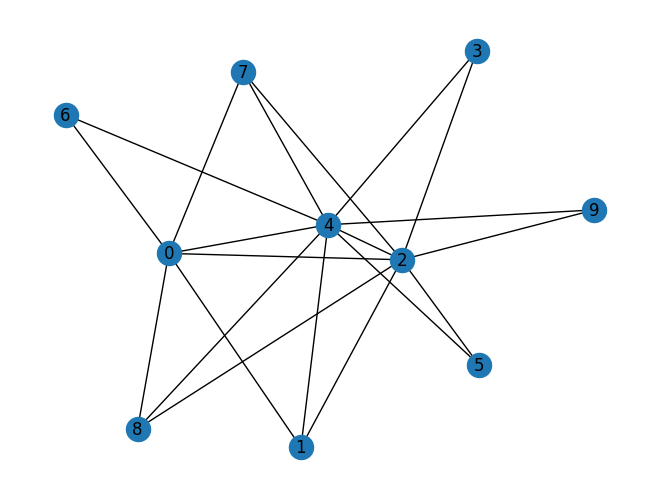

In [70]:
nx.draw(G, with_labels=True)
plt.show()

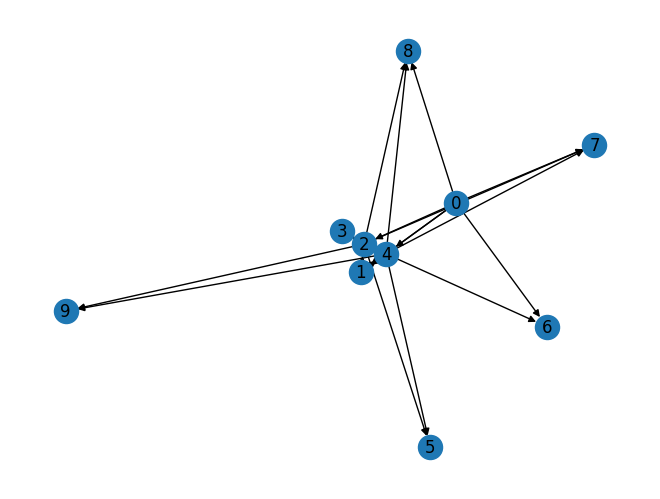

In [71]:
nx_graph = dgl_G.to_networkx()

# Plot the NetworkX graph
nx.draw(nx_graph, with_labels=True)
plt.show()

In [72]:
pip install gensim

  Using cached gensim-4.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.5 kB)
Using cached gensim-4.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [74]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-25')
label_names = ['down', 'go', 'left', 'no', 'right', 'stop' ,'up', 'yes']
word_embding = glove_vectors[label_names]

[==================================================] 100.0% 104.8/104.8MB downloaded


In [76]:
label_names = ['down', 'go', 'left', 'no', 'right', 'stop' ,'up', 'yes']
word_embding = glove_vectors[label_names]

array([[-3.5193e-01,  3.9902e-01,  5.4514e-01,  2.1062e-01, -5.3687e-01,
         6.2072e-01,  8.5850e-01, -1.4018e-01,  8.6434e-02,  6.8927e-01,
        -1.3251e-01,  7.1737e-01, -4.9141e+00,  1.8457e-01,  2.1160e-01,
         7.4888e-02,  3.7614e-02, -6.7350e-01, -3.9543e-01, -7.3271e-01,
        -2.1644e-01,  1.9091e-01,  1.5185e+00, -1.8719e-01,  1.3657e-01],
       [-3.1725e-01,  8.1507e-01, -7.4880e-02, -5.9748e-01, -1.4955e+00,
         1.4265e-01,  1.3831e+00,  1.7203e-01,  9.7658e-02, -6.3706e-03,
        -9.0485e-01, -1.3208e-01, -5.0127e+00, -2.6589e-01, -1.5179e-01,
         3.0527e-03,  1.2332e-01, -1.5430e+00, -8.5517e-01, -4.5213e-01,
        -1.5237e-01, -1.3811e-01,  7.3457e-01,  1.6482e-01,  2.9579e-01],
       [-3.3006e-01,  4.1903e-01,  1.0031e+00, -3.6707e-01, -4.9538e-01,
        -1.0345e-01,  9.3965e-01, -7.0208e-01, -4.4488e-01,  4.7163e-01,
         1.3751e-01,  7.2305e-01, -4.5968e+00,  3.9580e-01,  1.8975e-01,
        -3.7606e-01,  3.8570e-01, -3.0679e-01, -2

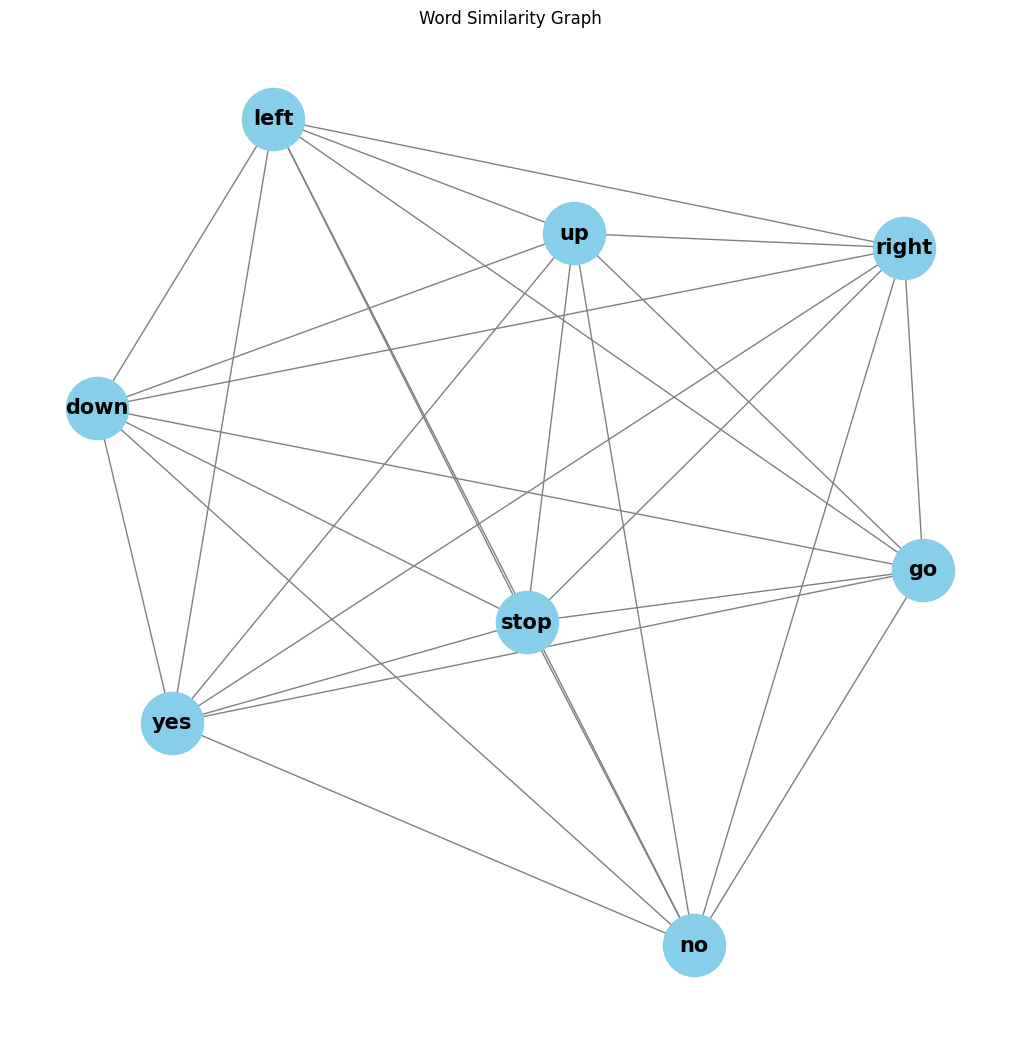

In [77]:
import gensim.downloader as api
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the GloVe Twitter embeddings
glove_vectors = api.load('glove-twitter-25')

# Define the list of words
label_names = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

# Retrieve embeddings for each word in the list
word_embeddings = np.array([glove_vectors[word] for word in label_names])

# Compute the cosine similarity matrix
similarity_matrix = np.dot(word_embeddings, word_embeddings.T)
norms = np.linalg.norm(word_embeddings, axis=1)
similarity_matrix = similarity_matrix / norms[:, np.newaxis]
similarity_matrix = similarity_matrix / norms[np.newaxis, :]

# Apply threshold
threshold = 0.5
similarity_matrix[similarity_matrix < threshold] = 0

# Set diagonal to 0 to avoid self-loops
np.fill_diagonal(similarity_matrix, 0)

# Create a graph from the similarity matrix
G = nx.from_numpy_array(similarity_matrix)
mapping = {i: label_names[i] for i in range(len(label_names))}
G = nx.relabel_nodes(G, mapping)

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')
plt.title('Word Similarity Graph')
plt.show()


Graph(num_nodes=8, num_edges=28,
      ndata_schemes={'feat': Scheme(shape=(25,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})
tensor([[-3.5193e-01,  3.9902e-01,  5.4514e-01,  2.1062e-01, -5.3687e-01,
          6.2072e-01,  8.5850e-01, -1.4018e-01,  8.6434e-02,  6.8927e-01,
         -1.3251e-01,  7.1737e-01, -4.9141e+00,  1.8457e-01,  2.1160e-01,
          7.4888e-02,  3.7614e-02, -6.7350e-01, -3.9543e-01, -7.3271e-01,
         -2.1644e-01,  1.9091e-01,  1.5185e+00, -1.8719e-01,  1.3657e-01],
        [-3.1725e-01,  8.1507e-01, -7.4880e-02, -5.9748e-01, -1.4955e+00,
          1.4265e-01,  1.3831e+00,  1.7203e-01,  9.7658e-02, -6.3706e-03,
         -9.0485e-01, -1.3208e-01, -5.0127e+00, -2.6589e-01, -1.5179e-01,
          3.0527e-03,  1.2332e-01, -1.5430e+00, -8.5517e-01, -4.5213e-01,
         -1.5237e-01, -1.3811e-01,  7.3457e-01,  1.6482e-01,  2.9579e-01],
        [-3.3006e-01,  4.1903e-01,  1

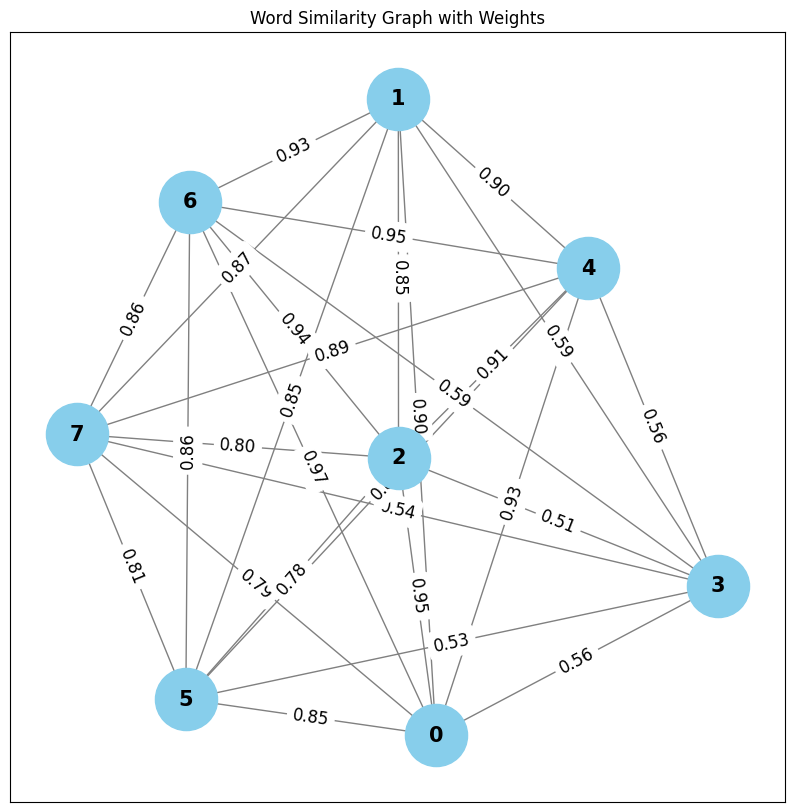

In [82]:
import gensim.downloader as api
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import dgl
import torch

# Load the GloVe Twitter embeddings
glove_vectors = api.load('glove-twitter-25')

# Define the list of words
label_names = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

# Retrieve embeddings for each word in the list
word_embeddings = np.array([glove_vectors[word] for word in label_names])

# Compute the cosine similarity matrix
similarity_matrix = np.dot(word_embeddings, word_embeddings.T)
norms = np.linalg.norm(word_embeddings, axis=1)
similarity_matrix = similarity_matrix / norms[:, np.newaxis]
similarity_matrix = similarity_matrix / norms[np.newaxis, :]

# Apply threshold
threshold = 0.5
similarity_matrix[similarity_matrix < threshold] = 0

# Set diagonal to 0 to avoid self-loops
np.fill_diagonal(similarity_matrix, 0)

# Create a NetworkX graph from the similarity matrix with weights
nx_graph = nx.from_numpy_array(similarity_matrix)
mapping = {i: label_names[i] for i in range(len(label_names))}
#nx_graph = nx.relabel_nodes(nx_graph, mapping)

def build_dgl_graph(nx_graph):
    # Créer un graphe DGL vide
    dgl_graph = dgl.DGLGraph()

    # Ajouter des nœuds au graphe DGL
    dgl_graph.add_nodes(nx_graph.number_of_nodes())

    # Ajouter des arêtes au graphe DGL avec les poids
    src, dst, weights = zip(*[(int(src), int(dst), data['weight']) for src, dst, data in nx_graph.edges(data=True)])
    dgl_graph.add_edges(src, dst)
    dgl_graph.edata['weight'] = torch.tensor(weights,dtype=torch.float)

    return dgl_graph
# Convert NetworkX graph to a DGL graph without edge attributes
dgl_graph = build_dgl_graph(nx_graph)


# Add node features and labels to DGL graph
dgl_graph.ndata['feat'] = torch.tensor(word_embeddings, dtype=torch.float32)
dgl_graph.ndata['label'] = torch.tensor([label_names.index(label) for label in label_names], dtype=torch.long)

# Print the DGL graph to verify
print(dgl_graph)
print(dgl_graph.ndata['feat'])
print(dgl_graph.ndata['label'])
print(dgl_graph.edata['weight'])

# Plot the graph (optional, for visualization)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_graph)
edges = nx_graph.edges(data=True)

# Draw nodes
nx.draw_networkx_nodes(nx_graph, pos, node_color='skyblue', node_size=2000)

# Draw edges with weights
nx.draw_networkx_edges(nx_graph, pos, edgelist=edges, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(nx_graph, pos, font_size=15, font_weight='bold')

# Draw edge labels (weights)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=12)

plt.title('Word Similarity Graph with Weights')
plt.show()


In [ ]:
import dgl
import torch

# Step 1: Load or create your existing simple (homogeneous) DGL graphs
# Example graph 1
src1 = torch.tensor([0, 1, 2])
dst1 = torch.tensor([1, 2, 3])
graph1 = dgl.graph((src1, dst1))

# Example graph 2
src2 = torch.tensor([0, 1, 2])
dst2 = torch.tensor([2, 3, 4])
graph2 = dgl.graph((src2, dst2))

# Step 2: Define the node and edge types for the heterogeneous graph
# Assume graph1 represents 'user' -> 'item' interactions
# and graph2 represents 'item' -> 'category' relationships

# Extract nodes and edges from graph1
src1, dst1 = graph1.edges()

# Extract nodes and edges from graph2
src2, dst2 = graph2.edges()

# Step 3: Combine the edges into a data dictionary for the heterogeneous graph
data_dict = {
    ('user', 'buys', 'item'): (src1, dst1),
    ('item', 'belongs_to', 'category'): (src2, dst2)
}

# Step 4: Create the heterogeneous graph
hetero_graph = dgl.heterograph(data_dict)

# Print the heterogeneous graph to verify
print(hetero_graph)


In [191]:
import dgl
from dgl.data.utils import load_graphs
glist1, label_dict = load_graphs(os.path.join("kws_graph.dgl"))
glist2, _ = load_graphs(os.path.join("dgl_words_graph.bin"))

dgl_G_acoustic = glist1[0]  
dgl_G_words = glist2[0] 

graph1 =  dgl_G_acoustic
graph2 =  dgl_G_words


# Step 2: Define the node and edge types for the heterogeneous graph
# Assume graph1 represents 'user' -> 'item' interactions
# and graph2 represents 'item' -> 'category' relationships

# Extract nodes and edges from graph1
src1, dst1 = graph1.edges()

# Extract nodes and edges from graph2
src2, dst2 = graph2.edges()


# Step 3: Combine the edges into a data dictionary for the heterogeneous graph
data_dict = {
    ('acoustic', 'sim', 'acoustic'): (src1, dst1),
    ('word', 'sim', 'word'): (src2, dst2)
}

# Step 4: Create the heterogeneous graph
hetero_graph = dgl.heterograph(data_dict)

# Print the heterogeneous graph to verify
print(hetero_graph)




Graph(num_nodes={'acoustic': 5, 'word': 8},
      num_edges={('acoustic', 'sim', 'acoustic'): 5, ('word', 'sim', 'word'): 28},
      metagraph=[('acoustic', 'acoustic', 'sim'), ('word', 'word', 'sim')])


In [196]:
graph1.ndata['label']

tensor([1, 3, 2, 1, 7])

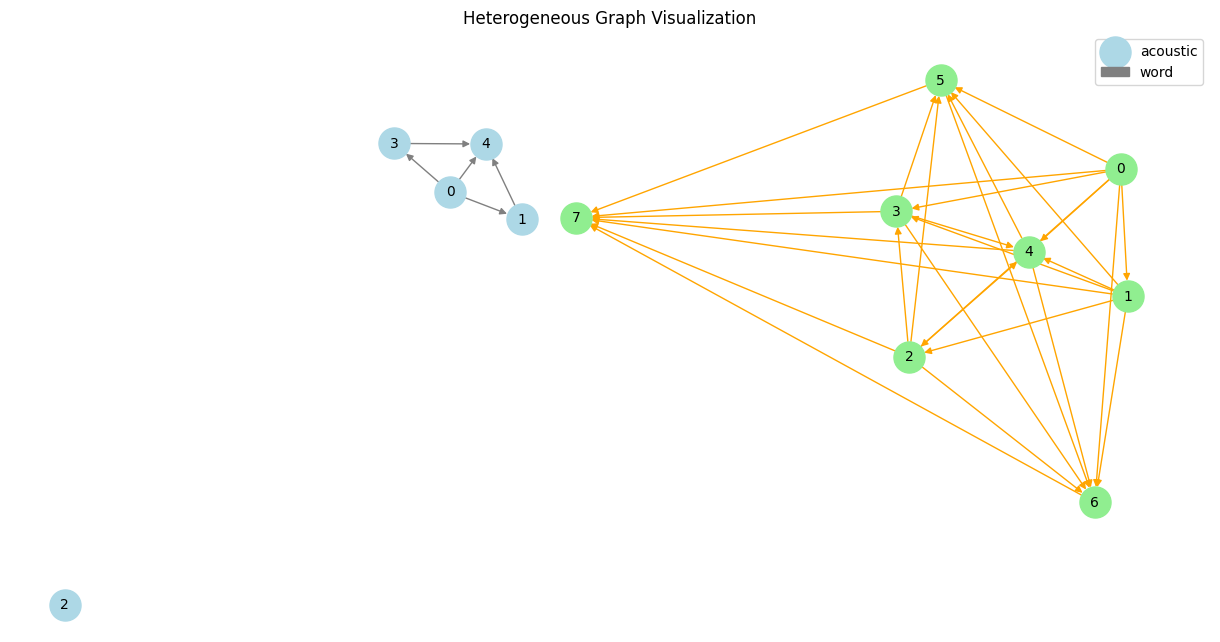

In [192]:
# Convert DGL subgraphs to NetworkX graphs for each edge type
acoustic_g = hetero_graph['acoustic', 'sim', 'acoustic'].to_networkx()
word_g = hetero_graph['word', 'sim', 'word'].to_networkx()

# Plot the graphs
plt.figure(figsize=(12, 6))

# Draw acoustic graph
pos_acoustic = nx.spring_layout(acoustic_g, seed=42)  # positions for acoustic nodes
nx.draw(acoustic_g, pos_acoustic, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, font_color='black', label='acoustic')

# Draw word graph
pos_word = nx.spring_layout(word_g, seed=42)  # positions for word nodes
# Adjust positions to not overlap
pos_word = {k: (v[0] + 1.5, v[1]) for k, v in pos_word.items()}
nx.draw(word_g, pos_word, with_labels=True, node_color='lightgreen', edge_color='orange', node_size=500, font_size=10, font_color='black', label='word')

# Add legends
plt.legend(['acoustic', 'word'])
plt.title('Heterogeneous Graph Visualization')
plt.show()

1/1 [==============================] - 0s 24ms/step
Graph(num_nodes={'acoustic': 5, 'word': 8},
      num_edges={('acoustic', 'related_to', 'word'): 4, ('acoustic', 'sim_tic', 'acoustic'): 5, ('word', 'sim_w', 'word'): 28},
      metagraph=[('acoustic', 'word', 'related_to'), ('acoustic', 'acoustic', 'sim_tic'), ('word', 'word', 'sim_w')])


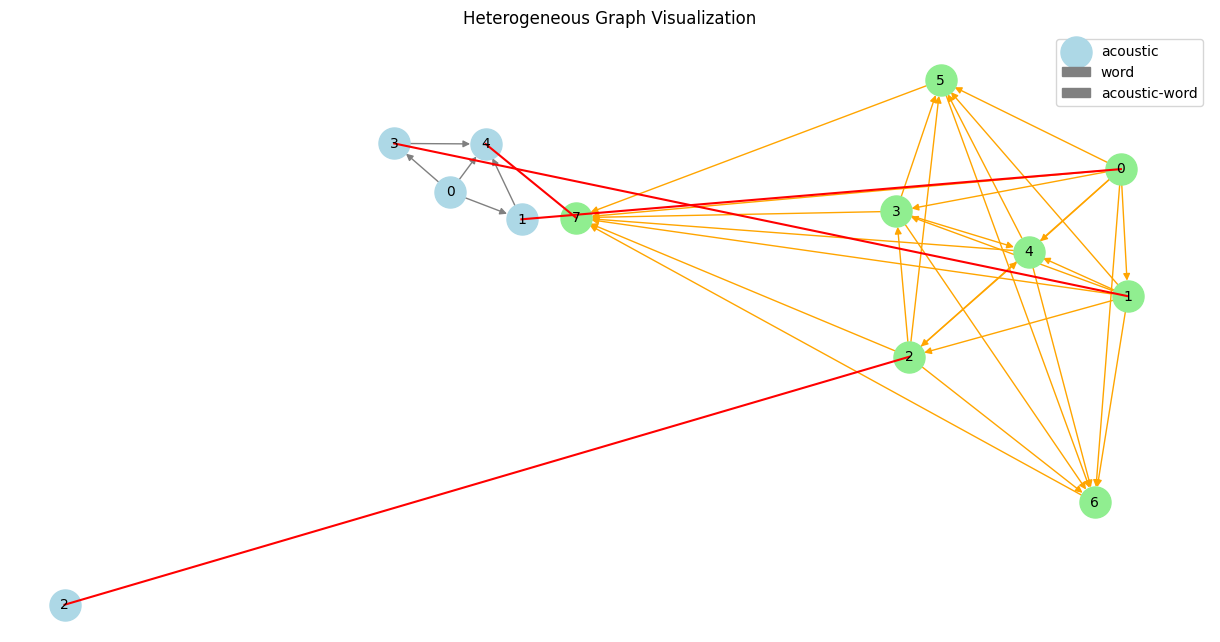

In [232]:
import dgl
from dgl.data.utils import load_graphs
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Load the simple DGL graphs
glist1, label_dict = load_graphs(os.path.join("kws_graph.dgl"))
glist2, _ = load_graphs(os.path.join("dgl_words_graph.bin"))

dgl_G_acoustic = glist1[0]
dgl_G_words = glist2[0]

graph1 = dgl_G_acoustic
graph2 = dgl_G_words

# Extract nodes and edges from graph1
src1, dst1 = graph1.edges()
edge_weights1 = graph1.edata['weight']  # Assume edge weights are stored in 'weight'

# Extract nodes and edges from graph2
src2, dst2 = graph2.edges()
edge_weights2 = graph2.edata['weight']  # Assume edge weights are stored in 'weight'

# Step 1: Simulate the softmax probabilities from a model
# Example softmax probabilities for each acoustic node (random for demonstration purposes)
num_acoustic_nodes = graph1.num_nodes()
num_word_nodes = graph2.num_nodes()
softmax_probabilities = model.predict(tf.convert_to_tensor(graph1.ndata['feat'].cpu().numpy()))

# Step 2: Define the threshold probability
threshold_probability = 0.3

# Step 3: Create links between acoustic and word nodes based on probabilities exceeding the threshold
links_acoustic_word = []
probabilities_acoustic_word = []
for i in range(num_acoustic_nodes):
    for j in range(num_word_nodes):
        if softmax_probabilities[i, j] > threshold_probability:
            links_acoustic_word.append((i, j))
            probabilities_acoustic_word.append(softmax_probabilities[i, j])

# Combine the edges into a data dictionary for the heterogeneous graph
data_dict = {
    ('acoustic', 'sim_tic', 'acoustic'): (src1, dst1),
    ('word', 'sim_w', 'word'): (src2, dst2),
    ('acoustic', 'related_to', 'word'): (torch.tensor([src for src, dst in links_acoustic_word]), torch.tensor([dst for src, dst in links_acoustic_word]))
}

# Create the heterogeneous graph
hetero_graph = dgl.heterograph(data_dict)

# Add node features and labels
hetero_graph.nodes['acoustic'].data['feat'] = graph1.ndata['feat']
hetero_graph.nodes['word'].data['feat'] = graph2.ndata['feat']
hetero_graph.nodes['acoustic'].data['label'] = graph1.ndata['label']
hetero_graph.nodes['word'].data['label'] = graph2.ndata['label']

# Add edge weights
hetero_graph.edges['sim_tic'].data['weight'] = edge_weights1
hetero_graph.edges['sim_w'].data['weight'] = edge_weights2
hetero_graph.edges['related_to'].data['weight'] = torch.tensor(probabilities_acoustic_word)


# Flatten the features of the acoustic nodes
acoustic_features = hetero_graph.nodes['acoustic'].data['feat']
flattened_acoustic_features = acoustic_features.view(acoustic_features.shape[0], -1)  # Flatten the features

# Determine the length of the flattened features
flattened_length = flattened_acoustic_features.shape[1]

# Pad the features of the word nodes to match the flattened length of acoustic features
word_features = hetero_graph.nodes['word'].data['feat']
word_feat_shape = word_features.shape
padded_word_features = torch.zeros((word_feat_shape[0], flattened_length))  # Initialize padded feature tensor

# Copy existing word features into the padded tensor
padded_word_features[:, :word_feat_shape[1]] = word_features

# Assign the padded features back to the word nodes in the graph
hetero_graph.nodes['word'].data['feat'] = padded_word_features
# Print the heterogeneous graph to verify
print(hetero_graph)

# Convert DGL subgraphs to NetworkX graphs for each edge type
acoustic_g = hetero_graph['acoustic', 'sim_tic', 'acoustic'].to_networkx()
word_g = hetero_graph['word', 'sim_w', 'word'].to_networkx()

# Plot the graphs
plt.figure(figsize=(12, 6))

# Draw acoustic graph
pos_acoustic = nx.spring_layout(acoustic_g, seed=42)  # positions for acoustic nodes
nx.draw(acoustic_g, pos_acoustic, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10, font_color='black', label='acoustic')

# Draw word graph
pos_word = nx.spring_layout(word_g, seed=42)  # positions for word nodes
# Adjust positions to not overlap
pos_word = {k: (v[0] + 1.5, v[1]) for k, v in pos_word.items()}
nx.draw(word_g, pos_word, with_labels=True, node_color='lightgreen', edge_color='orange', node_size=500, font_size=10, font_color='black', label='word')

# Draw acoustic-word graph
for link in links_acoustic_word:
    plt.plot([pos_acoustic[link[0]][0], pos_word[link[1]][0]], [pos_acoustic[link[0]][1], pos_word[link[1]][1]], color='red')

# Add legends
plt.legend(['acoustic', 'word', 'acoustic-word'])
plt.title('Heterogeneous Graph Visualization')
plt.show()


In [ ]:
acoustic = hetero_graph['acoustic', 'sim_tic', 'acoustic']
acoustic.ndata['label']

In [204]:
hetero_graph['acoustic', 'related_to', 'word'].edges()

(tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
         4]),
 tensor([2, 4, 6, 1, 2, 3, 4, 5, 6, 1, 2, 5, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 3, 5,
         6]))

In [188]:
src2, dst2

(tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4,
         4, 5, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 4, 5, 6, 7, 5, 6,
         7, 6, 7, 7]))

In [133]:
imported = tf.saved_model.load("saved")

In [184]:
model.predict(tf.convert_to_tensor(dgl_G_acoustic.ndata['feat'].cpu().numpy()))

1/1 [==============================] - 0s 110ms/step


array([[2.9791655e-02, 8.6834908e-01, 5.5449689e-03, 5.3115141e-02,
        3.9654095e-03, 2.8853331e-02, 9.9473195e-03, 4.3312964e-04],
       [9.6482167e-04, 2.8039420e-03, 1.3440955e-08, 9.9623102e-01,
        9.7145186e-14, 5.3162942e-08, 1.0772486e-07, 4.6740890e-08],
       [1.1131001e-10, 4.2443493e-11, 9.9999547e-01, 2.1595735e-10,
        3.3385081e-07, 2.0843211e-07, 4.2614207e-07, 3.4835859e-06],
       [7.4741308e-04, 8.5817486e-01, 3.1746262e-07, 1.4107534e-01,
        5.3550542e-07, 1.4357755e-07, 1.3581347e-06, 1.0408338e-09],
       [2.0470877e-17, 5.5763852e-14, 1.8978075e-19, 1.5079955e-16,
        1.1165304e-22, 3.3188372e-17, 1.7840742e-22, 1.0000000e+00]],
      dtype=float32)

In [135]:
acoustic_model =  imported.model

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [40]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [41]:
input_shape

NameError: name 'input_shape' is not defined

In [42]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (124, 64, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [44]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 12s 114ms/step - loss: 1.7119 - accuracy: 0.3798 - val_loss: 1.4630 - val_accuracy: 0.4987
Epoch 2/10
100/100 [==============================] - 11s 106ms/step - loss: 1.1418 - accuracy: 0.6003 - val_loss: 1.2310 - val_accuracy: 0.5755
Epoch 3/10
100/100 [==============================] - 11s 107ms/step - loss: 0.8764 - accuracy: 0.7052 - val_loss: 1.1326 - val_accuracy: 0.6224
Epoch 4/10
100/100 [==============================] - 11s 108ms/step - loss: 0.7086 - accuracy: 0.7597 - val_loss: 1.0688 - val_accuracy: 0.6497
Epoch 5/10
100/100 [==============================] - 11s 107ms/step - loss: 0.5966 - accuracy: 0.8006 - val_loss: 1.0420 - val_accuracy: 0.6536
Epoch 6/10
100/100 [==============================] - 11s 110ms/step - loss: 0.5129 - accuracy: 0.8228 - val_loss: 1.0792 - val_accuracy: 0.6484
Epoch 7/10
100/100 [==============================] - 11s 105ms/step - loss: 0.4521 - accuracy: 0.8500 - val_loss: 1.0184 - val_ac

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

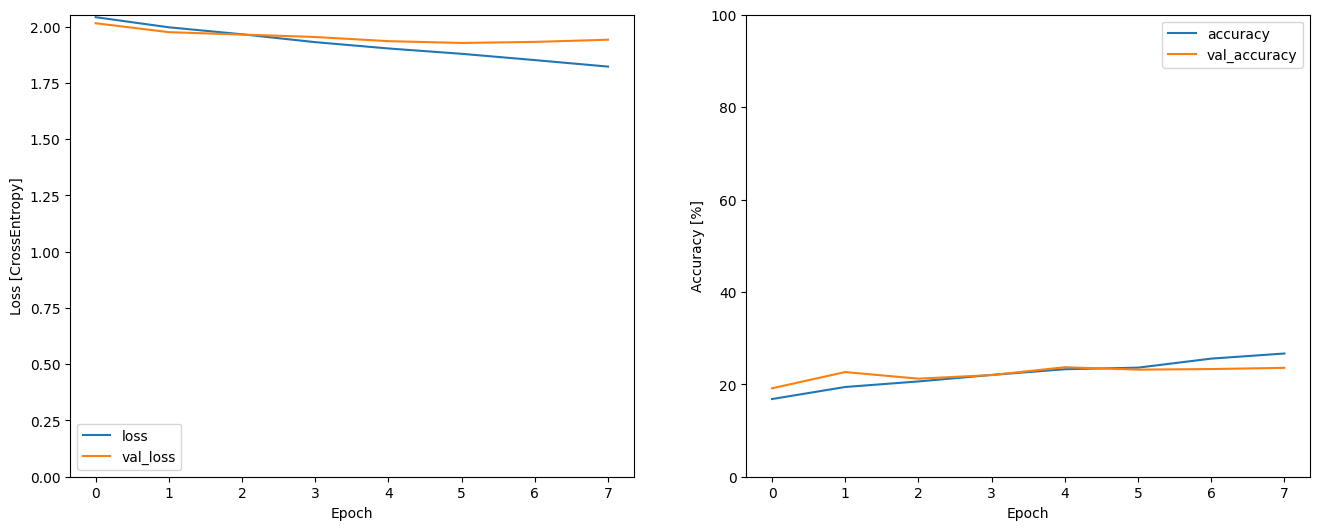

In [93]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [94]:
model.save('models/model.h5')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [215]:
model.evaluate(test_spectrogram_ds, return_dict=True)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [216]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 0s 21ms/step


In [217]:
y_pred

array([[0.15402126, 0.10804043, 0.1304345 , ..., 0.12386833, 0.13095173,
        0.07301682],
       [0.11890796, 0.13064706, 0.12473112, ..., 0.12728934, 0.11543858,
        0.12130905],
       [0.11830693, 0.1259468 , 0.12740494, ..., 0.12323558, 0.12231276,
        0.12304957],
       ...,
       [0.11997677, 0.1252707 , 0.1268728 , ..., 0.12525566, 0.12165279,
        0.1233722 ],
       [0.17693903, 0.116961  , 0.14397708, ..., 0.12833081, 0.12889825,
        0.0847244 ],
       [0.09673413, 0.11882049, 0.14921458, ..., 0.15829544, 0.12211896,
        0.09537414]], dtype=float32)

In [218]:
y_pred = tf.argmax(y_pred, axis=1)

In [219]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

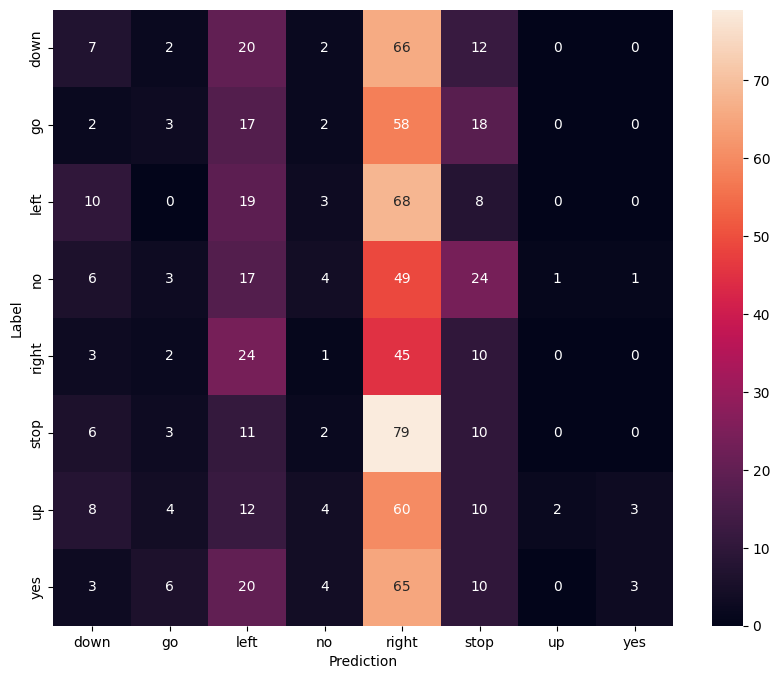

In [220]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

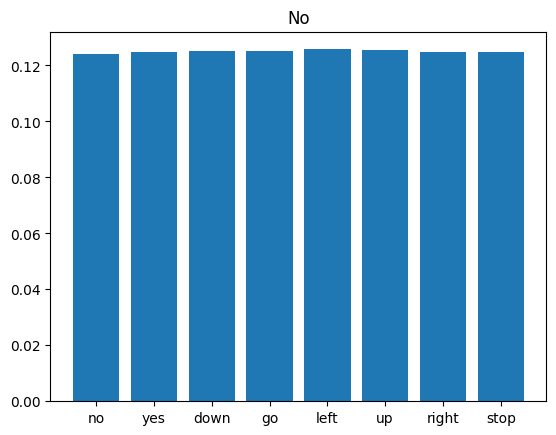

In [221]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [222]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
        
    print(type(x))
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
  
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}
  def get_model():
      return model

Test run the "export" model:

In [223]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[0.11835618, 0.1244799 , 0.12633434, 0.12679729, 0.13126071,
         0.12786241, 0.12242761, 0.12248164]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [224]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[0.11835618, 0.1244799 , 0.12633434, 0.12679729, 0.13126071,
         0.12786241, 0.12242761, 0.12248164]], dtype=float32)>}

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.